# sen2like in openEO

### sen2like

The Sen2Like, demonstration processor has been developed by ESA in the framework of the EU Copernicus programme (https://www.copernicus.eu/). The main goal of Sen2Like is to generate Sentinel-2 like harmonised/fused surface reflectances with higher periodicity by integrating additional compatible optical mission sensors.

https://github.com/senbox-org/sen2like

### openEO

openEO provides an option to run the sen2like processor on the requested extent on an openEO backend. The backend takes care of getting the required input data and the computational resources to run sen2like on. openEO users can start sen2like jobs on the backend and download the results as in the example given above.

https://openeo.cloud/

### Results

The outputs of sen2like are stored in Sentinel 2 - like .SAFE folders. In openEO, users can choose between the output formats NetCDF and GeoTiff. For the sen2like processing in openEO, it is now additionally possible to download the original .SAFE folders. To retrieve .SAFE folders, the export_original_files parameter needs to be set to True. If the main interest is in the openEO results, it can be set to False. (See below)

In [1]:
import openeo

In [2]:
eodc = "https://openeo.eodc.eu/openeo/1.1.0/"

In [3]:
conn = openeo.connect(eodc).authenticate_oidc()

Authenticated using refresh token.


### Details in openEO's sen2like processing 

To create an openeo process graph, we define the spatial and temporal extent, we want to process. For sen2like, we additionally set the parameters: 
- target_product, which can be L2F or L2H
- the bands, out of: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11','B12'
- the cloud_cover, which is between 1 and 100. The lower the value, the lower the cloud cover for the files must be - files with higher cloud cover are ignored.
- export_original_files: can be True or False - if True, the .SAFE folders are an output of the openEO process as well.

In [4]:
collection      = 'SENTINEL2_L1C'
spatial_extent  = {"west": 15.6, "east": 15.7, "south": 46.5, "north": 46.6}
temporal_extent = ["2023-09-01", "2023-09-30"]

S2 = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent)
sen2like = S2.process('sen2like', {
    'spatial_extent': spatial_extent, 
    'temporal_extent': temporal_extent, 
    'target_product': 'L2F', 
    'bands': ["B04", "B08"],
    'export_original_files': False,
    'cloud_cover': 50}) 

Additionally, we can make use of other openEO processes as shown below. The nir and red bands of the data are combined to the NDVI and stored in NetCDF files.

In [5]:
sen2like_ndvi = sen2like.ndvi(nir="B08", red="B04")

sen2like_nc = sen2like_ndvi.save_result(format="NetCDF")

We create and start the openEO batch job:

In [6]:
job = sen2like_nc.create_job().start_job()

In [7]:
job

<BatchJob job_id='bf268803-6803-4d79-a929-749eedf44ed0'>

In [8]:
job.status()

'finished'

When the job is finished, the results can be downloaded. 

In [9]:
results = job.get_results()
metadata = results.get_metadata()

sen2like produces openEO NetCDF outputs per default in the Equi7 grid, which can be found in the metadata assets: E.g.: 

In [10]:
metadata['assets']['EU010M_E051N014T1_20230907T100753.nc']

{'href': 'https://openeo.eodc.eu/openeo/1.1.0/files/bf268803-6803-4d79-a929-749eedf44ed0/OPENEO/results/EU010M_E051N014T1_20230907T100753.nc?Expires=1710511926&KeyName=SIGN_KEY_1&UserId=2c3c496d-935a-4f39-b246-da2da4e07a6a&Signature=A7ctd0-UHoqKD9UMQUknEY2DjGg=',
 'title': 'EU010M_E051N014T1_20230907T100753',
 'equi7:proj': '+proj=aeqd +lat_0=53 +lon_0=24 +x_0=5837287.81977 +y_0=2121415.69617 +datum=WGS84 +units=m +no_defs',
 'roles': ['data']}

### Explore the openEO results

In [15]:
data = xr.open_mfdataset("EU010M_E051N014T1_20230930T000000.nc")

data

<xarray.Dataset>
Dimensions:      (y: 1193, x: 755)
Coordinates:
  * y            (y) float64 1.446e+06 1.446e+06 ... 1.434e+06 1.434e+06
  * x            (x) float64 5.192e+06 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
    spatial_ref  int32 ...
    t            datetime64[ns] ...
Data variables:
    B02          (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
Attributes:
    nodata:   -9999
    crs:      PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WG...

In [12]:
data = xr.open_mfdataset("EU010M_E051N014T1_20230907T100753.nc")

data

<xarray.Dataset>
Dimensions:      (y: 1193, x: 755)
Coordinates:
  * y            (y) float64 1.446e+06 1.446e+06 ... 1.434e+06 1.434e+06
  * x            (x) float64 5.192e+06 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
    spatial_ref  int32 ...
    t            datetime64[ns] ...
Data variables:
    name         (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
Attributes:
    nodata:   -9999
    crs:      PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WG...

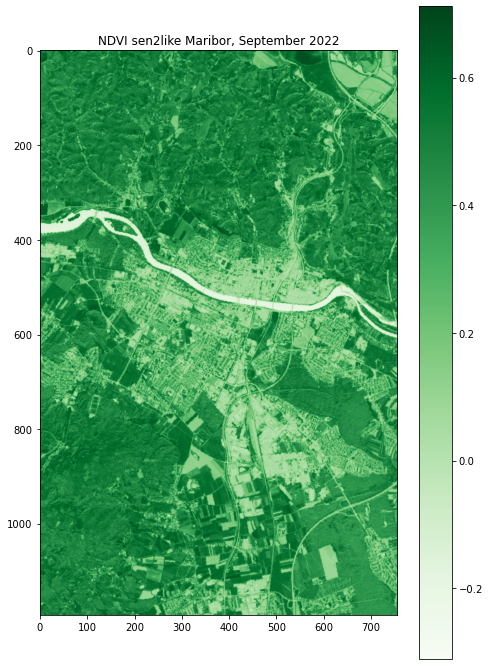

In [13]:
data = data.name

plt.figure(figsize=(8,12))
plt.title("NDVI sen2like Maribor, September 2022")
plt.imshow(data,cmap='Greens')
plt.colorbar()